GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading model ...
Model loaded: 14.725575 million parameters
Setting up data ...
Start evaluation ...


/Users/doductai/anaconda3/envs/GNN_M1/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/doductai/anaconda3/envs/GNN_M1/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/val_acc        │    0.7040958404541016     │
└───────────────────────────┴───────────────────────────┘

[{'val/val_acc': 0.7040958404541016}]

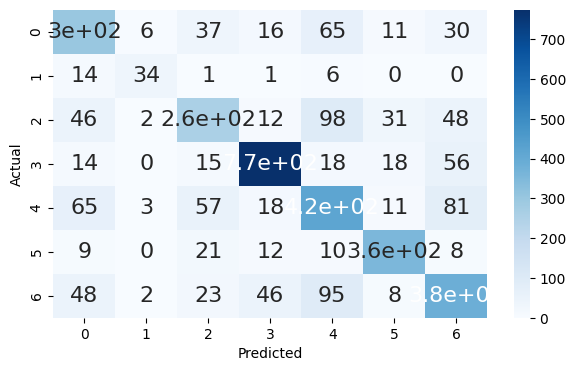

In [33]:
from model import vgg16
from data import FERDataModule
import pytorch_lightning
from hydra import initialize, compose
from pytorch_lightning.loggers import WandbLogger

# checkpoint path
ckpt_path="models/best_checkpoint.ckpt" 

# Manually initialize Hydra and load the config
with initialize(config_path="./configs",version_base="1.2"):
    cfg = compose(config_name="config")

print("Loading model ...")
model=vgg16.load_from_checkpoint(
    ckpt_path,
    layers=cfg.model.layers, 
    in_channel=cfg.processing.in_channel,
    num_classes=cfg.processing.num_classes,
    dropout=cfg.processing.dropout,
    lr=cfg.processing.lr)
print(f"Model loaded: {sum(p.numel() for p in model.parameters())/1e6} million parameters")

# set up trainer
wandb_logger = WandbLogger(project="Emotion Recognition", entity="doductai")
trainer = pytorch_lightning.Trainer(logger=wandb_logger)

# load data
print("Setting up data ...")
data=FERDataModule(batch_size=128,cut_size=44,device="mps")
# initialize data set
data.setup('fit')  
# Get the validation DataLoader
val_loader = data.val_dataloader()  

print("Start evaluation ...")
trainer.validate(model,val_loader)